# Auto Insurance Claims Fraud Detection - Modeling

Following the feature extraction in notebook `3-data-feature-engineering`, next step is to define and train some models.


* Choose, justify and apply a __model performance indicator__ (e.g. F1 score, true positive rate, within cluster sum of squared error, …) to assess your model and justify the choice of an algorithm
* Implement your algorithm in at least one __deep learning__ and at least one __non-deep learning__ algorithm, compare and document model performance
* Apply at least one additional iteration in the process model involving __at least the feature creation__ task and record impact on model performance (e.g. data normalizing, PCA, …)


### Metric
We are dealing with binarly classification and an unbalanced dataset, so the metric I've choose to use will be `f1-score`.

### Algorithms

Classic ML:
- Majority Class prediction: This simple model predicts the majority class for all instances.
- Logistic Regression: A linear model used for binary classification problems.
- Decision Tree: A tree-like model that splits data into branches based on features.
- Random Forests: An ensemble learning method that constructs multiple decision trees and merges their predictions.
- LightGBM: A gradient boosting framework that uses decision trees as base learners.
- XGBoost: Another gradient boosting framework known for its speed and performance.

Neural Network with logarithmic loss function (`binary_crossentropy`)
- single fully connected hidden layer with the same number of neurons as input variables
- single fully connected hidden layer with the halfed number of neurons from first model
- larger network with additional layer with 30 neurons after the first hidden layer


### Improvements
Feature extraction already done in `feature_ext` notebook.

## Loading dataset


In [1]:
# imports
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)  # Unlimited columns.
pd.options.mode.use_inf_as_na = True        # Any inf or -inf is treated as NA.

In [2]:
def to_csv(df, path):
    # Prepend dtypes to the top of df
    df2 = df.copy()
    df2.loc[-1] = df2.dtypes
    df2.index = df2.index + 1
    df2.sort_index(inplace=True)
    # Then save it to a csv
    df2.to_csv(path, index=False)
    
def read_csv(path):
    # Read types first line of csv
    dtypes = {key:value for (key,value) in pd.read_csv(path,    
              nrows=1).iloc[0].to_dict().items() if 'date' not in value}

    parse_dates = [key for (key,value) in pd.read_csv(path, 
                   nrows=1).iloc[0].to_dict().items() if 'date' in value]
    # Read the rest of the lines with the types from above
    return pd.read_csv(path, dtype=dtypes, parse_dates=parse_dates, skiprows=[1])

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics

def plot_roc(y_test, y_pred):
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    f, ax = plt.subplots(figsize=(5, 5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [4]:
train = read_csv('data/insurance_claims_train_features.csv')
test = read_csv('data/insurance_claims_test_features.csv')

X_train = train.drop('fraud_reported', axis=1)
y_train = train['fraud_reported']
X_test =  test.drop('fraud_reported', axis=1)
y_test = test['fraud_reported']

print(f'Dataset loaded. Training set: {train.shape}. Test set: {test.shape}')
print(f'X_train {X_train.shape}, y_train {y_train.shape} \n X_test {X_test.shape}, y_test {y_test.shape}')

Dataset loaded. Training set: (699, 98). Test set: (300, 98)
X_train (699, 97), y_train (699,) 
 X_test (300, 97), y_test (300,)


In [5]:
train.head()

,months_as_customer,age,policy_bind_date,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_date,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,policy_state_IN,policy_state_OH,policy_csl_250/500,policy_csl_500/1000,insured_sex_MALE,insured_education_level_College,insured_education_level_High School,insured_education_level_JD,insured_education_level_MD,insured_education_level_Masters,insured_education_level_PhD,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,insured_occupation_farming-fishing,insured_occupation_handlers-cleaners,insured_occupation_machine-op-inspct,insured_occupation_other-service,insured_occupation_priv-house-serv,insured_occupation_prof-specialty,insured_occupation_protective-serv,insured_occupation_sales,insured_occupation_tech-support,insured_occupation_transport-moving,insured_hobbies_cross-fit,insured_hobbies_other,insured_relationship_not-in-family,insured_relationship_other-relative,insured_relationship_own-child,insured_relationship_unmarried,insured_relationship_wife,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,collision_type_Front Collision,collision_type_Rear Collision,collision_type_Side Collision,incident_severity_Minor Damage,incident_severity_Total Loss,incident_severity_Trivial Damage,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police,incident_state_NY,incident_state_OH,incident_state_PA,incident_state_SC,incident_state_VA,incident_state_WV,incident_city_Columbus,incident_city_Hillsdale,incident_city_Northbend,incident_city_Northbrook,incident_city_Riverwood,incident_city_Springfield,property_damage_NO,property_damage_YES,police_report_available_NO,police_report_available_YES,auto_make_Audi,auto_make_BMW,auto_make_Chevrolet,auto_make_Dodge,auto_make_Ford,auto_make_Honda,auto_make_Jeep,auto_make_Mercedes,auto_make_Nissan,auto_make_Saab,auto_make_Suburu,auto_make_Toyota,auto_make_Volkswagen,"age_bins_(25, 45]","age_bins_(45, 64]",incident_month_of_year,incident_day_of_week,weekday,fraud_reported
0,328,48,2014-10-17,1000,1406.91,0,466132,53300,0,2015-01-25,5,1,1,2,71610,6510,13020,52080,2004,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,6,0,1
1,228,42,2006-06-27,2000,1197.22,5000000,468176,0,0,2015-01-21,8,1,0,0,5070,780,780,3510,2007,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,2,1,1
2,228,44,2014-06-06,1000,1583.91,6000000,610706,66000,-46000,2015-02-17,20,1,0,1,6500,1300,650,4550,2009,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,1,1,0
3,137,34,2000-06-04,1000,1333.35,0,441716,0,-77000,2015-01-13,0,3,0,0,78650,21450,7150,50050,2012,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,0
4,27,33,1997-02-05,500,1442.99,0,601734,0,0,2015-01-30,21,1,1,1,27700,2770,2770,22160,2012,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,4,1,0


## Classic ML algoritmhms:

### Majority Class prediction

In [6]:
pd.value_counts(y_train, normalize=True)

0    0.761087
1    0.238913
Name: fraud_reported, dtype: float64

Since more than half is just one category, we can predict that all of our target values are `0`. This will give us an _accuracy of 0.76_ on the training dataset. 

Let’s see what it does on the test dataset given that we chose f1-score as evaluation metric.

In [7]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = [0] * len(X_test)

print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
print(f'F1-score: {f1_score(y_pred, y_test)}')

Accuracy: 0.7333333333333333
F1-score: 0.0


C:\Users\efilgva\AppData\Local\Continuum\anaconda3\envs\py3.6-tf-avx2\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Although accuracy is 0.73, __f1-score is 0__. f1-score takes into account recall and sensitivity and penalizes false negatives. That is perfomance of our dumb majority class classifier.

In [8]:
print(f'F1-score: {f1_score([1] * len(X_test), y_test)}')

F1-score: 0.4210526315789474


If we predict all events are fraud, __f1-score is 0.42__. This is our baseline for very ineficient classifier.

### Logistic Regresion

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Keep only numberic columns (categorical are already OHE in feature_ext)
X_train_numerical = X_train.select_dtypes(exclude=['datetime64'])
X_test_numerical = X_test.select_dtypes(exclude=['datetime64'])

cv_score= cross_val_score(LogisticRegression(),
                          X_train_numerical, y_train,
                          scoring='f1',
                          cv=3,
                          n_jobs=-1,
                          verbose=True)

cv_score.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.3s finished


0.03139475038600103

Logistic Regression gives us a f1-score of __0.03__. Not much different than the Majority Class model.

### Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier

cv_score= cross_val_score(DecisionTreeClassifier(),
                          X_train_numerical, y_train,
                          scoring='f1',
                          cv=3,
                          n_jobs=-1,
                          verbose=True)

cv_score.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


0.561309238780532

Decision Tree gives us much better f1-score of __0.56__.

### RandomForests
Since our Decision Tree gave us a good result, let’s try the Random Forest classifier.

In [11]:
from sklearn.ensemble import RandomForestClassifier

cv_score= cross_val_score(RandomForestClassifier(n_estimators=10),
                          X_train_numerical, y_train,
                          scoring='f1',
                          cv=3,
                          n_jobs=-1,
                          verbose=True)

cv_score.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished


0.31003645477329683

Random Forest gives lower f1-score of __0.32__.

### LightGMB

In [12]:
#!pip install lightgbm

In [13]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [30]:
# https://www.kaggle.com/ezietsman/simple-python-lightgbm-example
import lightgbm as lgb

def run_lgb(X_train, X_test, y_train, y_test, test_df):
    
    parameters = {
        'application': 'binary',
        'objective': 'binary',
        'metric': 'f1',
        'is_unbalance': 'true',
        'boosting': 'gbdt',
        'num_leaves': 30,
        'feature_fraction': 0.5,
        'bagging_fraction': 0.5,
        'bagging_freq': 20,
        'learning_rate': 0.05,
        'verbose': 1
    }
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    evals_result = {}
        
    model = lgb.train(parameters,
                           train_data,
                           valid_sets=test_data,
                           num_boost_round=1000,
                           early_stopping_rounds=100,
                           verbose_eval=100,
                           evals_result=evals_result,
                           feval=lgb_f1_score)
    
    pred_test_y = model.predict(test_df, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result


In [31]:
y_pred_perc, model, evals_result = run_lgb(X_train_numerical, X_test_numerical,
                                      y_train, y_test, 
                                      X_test_numerical)
print("LightGBM Training Completed...")

C:\Users\efilgva\AppData\Local\Continuum\anaconda3\envs\py3.6-tf-avx2\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's f1: 0.588235
Early stopping, best iteration is:
[47]	valid_0's f1: 0.646341
LightGBM Training Completed...


In [32]:
y_pred = (y_pred_perc > 0.5).astype(int)

In [33]:
f1_score(y_test,y_pred)

0.646341463414634

In [40]:
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.86      0.87       220
           1       0.63      0.66      0.65        80

   micro avg       0.81      0.81      0.81       300
   macro avg       0.75      0.76      0.76       300
weighted avg       0.81      0.81      0.81       300



In [42]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(confusion_matrix(y_test, y_pred))

[[189  31]
 [ 27  53]]


In [43]:
fp

31

LightGBM improves to better f1-score of __0.64__.

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred)

0.7607954545454546

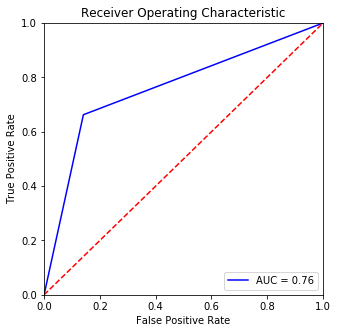

In [35]:
plot_roc(y_test, y_pred)

Plot feature importances...


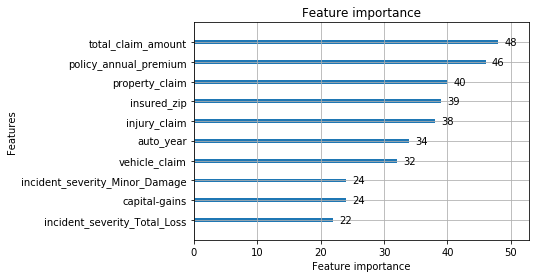

In [37]:
print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=10, importance_type='split')
plt.show()

Plot feature importances...


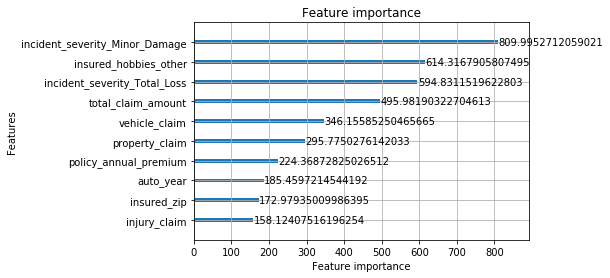

In [36]:
print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.show()

### XGBoost


In [20]:
#!pip install xgboost

In [21]:
import re
from xgboost import XGBClassifier

# in xgboost feature_names may not contain [, ] or <
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train_numerical.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_numerical.columns.values]
X_test_numerical.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test_numerical.columns.values]

In [22]:
# fit model on training data
model = XGBClassifier()
model.fit(X_train_numerical, y_train)

print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [23]:
# make predictions for test data
y_pred = model.predict(X_test_numerical)

By default, the predictions made by XGBoost are probabilities. Because this is a binary classification problem, each prediction is the probability of the input pattern belonging to the first class. We can easily convert them to binary class values by rounding them to 0 or 1.

In [24]:
predictions = [round(value) for value in y_pred]

In [25]:
# evaluate predictions
print("f1-Score: %.2f" % (f1_score(y_test, y_pred)))

f1-Score: 0.64


XGBoost gives f1-score of __0.64__ (on the fraud case). Similar to LightGBM.

In [26]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred)

0.7477272727272728

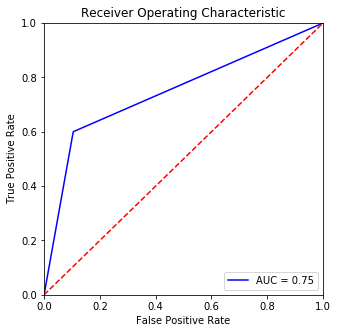

In [27]:
plot_roc(y_test, y_pred)

ROC curve shows indicates the best model is one that has around 0.6 True Positive Rate.

## Neural Networks 

during cv metric is `accuracy`, loss function is logarithmic loss function (`binary_crossentropy`)
1. single fully connected hidden layer with the same number of neurons as input variables
1. single fully connected hidden layer with the halfed number of neurons from first model
1. larger network with additional layer with 30 neurons after the first hidden layer

[Article](https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/)

In [49]:
# We will start off by importing all of the classes and functions we will need.
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Metrics have been removed from Keras core. You need to calculate them manually. They removed them on 2.0 version. Those metrics are all global metrics, but Keras works in batches. As a result, it might be more misleading than helpful. 

Since Keras calculate those metrics at the end of each batch, you could get different results from the "real" metrics. An alternative way would be to split your dataset in training and test and use the test part to predict the results. Then since you know the real labels, calculate precision and recall manually.

However, if you really need them, you can do it like this. [Article](https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model)

In [50]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [51]:
import time
import keras 

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

We are going to use scikit-learn to evaluate the model using __stratified k-fold cross validation__. This is a resampling technique that will provide an estimate of the performance of the model. It does this by splitting the data into k-parts, training the model on all parts except one which is held out as a test set to evaluate the performance of the model. This process is repeated k-times and the average score across all constructed models is used as a robust estimate of performance. It is stratified, meaning that it will look at the output values and attempt to balance the number of instances that belong to each class in the k-splits of the data.

To use Keras models with scikit-learn, we must use the __`KerasClassifier`__ wrapper. This class takes a function that creates and returns our neural network model. It also takes arguments that it will pass along to the call to `fit()` such as the number of epochs and the batch size.

### 1. Baseline Neural Network


Let’s start off by defining the function that creates our baseline model. Our model will have a single fully connected hidden layer with the _same number of neurons as input variables_. This is a good default starting point when creating neural networks.

The weights are initialized using a small Gaussian random number. The Rectifier activation function is used. The output layer contains a single neuron in order to make predictions. It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1 that can easily and automatically be converted to crisp class values.

Finally, we are using the logarithmic loss function (binary_crossentropy) during training, the preferred loss function for binary classification problems. The model also uses the efficient Adam optimization algorithm for gradient descent and accuracy metrics will be collected when the model is trained.

In [52]:
X_train_numerical.shape

(699, 95)

Consider tuning `batch_size` and `epochs` to get best model.

In [77]:
input_dim=95
batch_size=5
epochs=50

In [68]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(95, input_dim=input_dim, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [69]:
model = create_baseline()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 95)                9120      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 96        
Total params: 9,216
Trainable params: 9,216
Non-trainable params: 0
_________________________________________________________________


Now it is time to evaluate this model using stratified cross validation in the scikit-learn framework.

We pass the number of training epochs to the KerasClassifier, again using reasonable default values. Verbose output is also turned off given that the model will be created 10 times for the 10-fold cross validation being performed.

In [70]:
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, 
                            epochs=epochs, batch_size=batch_size, 
                            verbose=1)

kfold = StratifiedKFold(n_splits=10, shuffle=True)

results = cross_val_score(estimator, X_train_numerical, y_train, cv=kfold)

Epoch 1/100
628/628 [==============================] - 1s 866us/step - loss: 10.9788 - acc: 0.3121
Epoch 2/100
628/628 [==============================] - 0s 229us/step - loss: 10.9788 - acc: 0.3121
Epoch 3/100
628/628 [==============================] - 0s 205us/step - loss: 10.9788 - acc: 0.3121
Epoch 4/100
628/628 [==============================] - 0s 206us/step - loss: 10.9788 - acc: 0.3121
Epoch 5/100
628/628 [==============================] - 0s 218us/step - loss: 10.9788 - acc: 0.3121
Epoch 6/100
628/628 [==============================] - 0s 238us/step - loss: 10.9788 - acc: 0.3121
Epoch 7/100
628/628 [==============================] - 0s 205us/step - loss: 10.9788 - acc: 0.3121
Epoch 8/100
628/628 [==============================] - 0s 225us/step - loss: 10.9788 - acc: 0.3121
Epoch 9/100
628/628 [==============================] - 0s 209us/step - loss: 10.9788 - acc: 0.3121
Epoch 10/100
628/628 [==============================] - 0s 201us/step - loss: 10.9788 - acc: 0.3121
Epoch 11/

In [71]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 59.97% (20.42%)


We've achieved average accuracy accross 10 splits of __0.60__ with standard deviation of 0.20. This is huge variablity indicating that our model struggles to fit the data well.

In [78]:
# Fit the model
time_callback = TimeHistory()

model = create_baseline()
history = model.fit(X_train_numerical, y_train, validation_split=0.3, 
                    epochs=epochs, batch_size=batch_size, verbose=0, 
                    callbacks=[time_callback])

times = time_callback.times # to store times somewhere

In [89]:
# Predict with the model
y_pred = model.predict_classes(X_test_numerical, batch_size=batch_size, verbose=1)
predictions = [round(value[0]) for value in y_pred]

300/300 [==============================] - 0s 103us/step


In [90]:
from sklearn.metrics import classification_report

print(classification_report(y_test.astype(int), predictions))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       220
           1       0.20      0.19      0.19        80

   micro avg       0.58      0.58      0.58       300
   macro avg       0.46      0.46      0.46       300
weighted avg       0.57      0.58      0.58       300



In [91]:
f1_score(y_test, predictions)

0.19354838709677422

Baseline Neural Network gives weighted f1-score __0.19__. Very poor results. Confirmed by ROC curve indicating that we are better off random guessing than using this classifier!

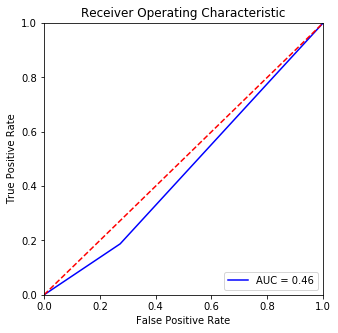

In [92]:
plot_roc(y_test, predictions)

### 2. Re-Run Baseline Model with Data Preparation

Neural network models are especially suitable to having consistent input values, both in scale and distribution.

An effective data preparation scheme for tabular data when building neural network models is __standardization__. This is where the data is rescaled such that the mean value for each attribute is 0 and the standard deviation is 1. This preserves Gaussian and Gaussian-like distributions whilst normalizing the central tendencies for each attribute.

We can use scikit-learn to perform the standardization of our Sonar dataset using the `StandardScaler` class.

Rather than performing the standardization on the entire dataset, it is good practice to train the standardization procedure on the training data within the pass of a cross-validation run and to use the trained standardization to prepare the “unseen” test fold. This makes standardization a step in model preparation in the cross-validation process and it prevents the algorithm having knowledge of “unseen” data during evaluation, knowledge that might be passed from the data preparation scheme like a crisper distribution.

We can achieve this in scikit-learn using a `Pipeline`. The pipeline is a wrapper that executes one or more models within a pass of the cross-validation procedure. Here, we can define a pipeline with the StandardScaler followed by our neural network model.

In [93]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning) # StandardScaler conversion warning

In [94]:
from sklearn.preprocessing import StandardScaler

# evaluate baseline model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=epochs, batch_size=batch_size, verbose=0)))
pipeline = Pipeline(estimators)

kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X_train_numerical, y_train, cv=kfold)

In [95]:
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Standardized: 81.97% (3.53%)


We do see nice lift in the mean accuracy and an important reduction in the standard deviation (average spread) of the accuracy scores for the model.

#### Predicting with standardized data
Let's precict with the model and calculate f1-score.

In [96]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=epochs, batch_size=batch_size, verbose=0)))
pipeline = Pipeline(estimators)

# Fit the model
history = pipeline.fit(X_train_numerical, y_train)

# Predict with the model
y_pred = pipeline.predict(X_test_numerical)
predictions = [round(value[0]) for value in y_pred]

In [97]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       220
           1       0.60      0.44      0.51        80

   micro avg       0.77      0.77      0.77       300
   macro avg       0.71      0.67      0.68       300
weighted avg       0.76      0.77      0.76       300



In [98]:
f1_score(y_test, predictions)

0.5072463768115941

With standardized data Neural Network gives f1-score __0.51__.

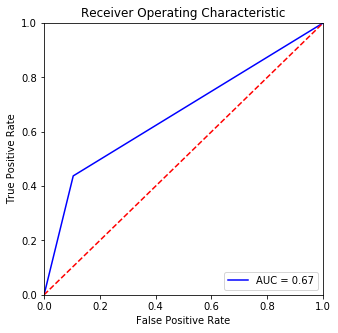

In [99]:
plot_roc(y_test, predictions)

### 3. Tuning Layers and Number of Neurons in The Model
There are many things to tune on a neural network, such as the weight initialization, activation functions, optimization procedure and so on.

One aspect that may have an outsized effect is the structure of the network itself called the network topology. In this section, we take a look at two experiments on the structure of the network: making it smaller and making it larger.

These are good experiments to perform when tuning a neural network on your problem.

### 3.1 Evaluate a Smaller Network
I suspect that there is a lot of redundancy in the input variables for this problem.

The data describes many characterstics of the insurance claim many of them probably redundant. Perhaps some of those characteristics are more relevant than others. We can force a type of feature extraction by the network by restricting the representational space in the first hidden layer.

In this experiment, we take our baseline model with 95 neurons in the hidden layer and reduce it by half to 45. This will put pressure on the network during training to pick out the most important structure in the input data to model.

We will also standardize the data as in the previous experiment with data preparation and try to take advantage of the small lift in performance.

In [100]:
# smaller model
def create_smaller():
    # create model
    model = Sequential()
    model.add(Dense(45, input_dim=input_dim, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [101]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_smaller, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X_train_numerical, y_train, cv=kfold)

In [102]:
print("Smaller: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Smaller: 81.85% (4.18%)


We can see that we have a very slight boost in the mean estimated accuracy and an important reduction in the standard deviation (average spread) of the accuracy scores for the model.

This is a great result because we are doing slightly better with a network half the size, which in turn takes half the time to train.

#### Predicting with smaller network

In [111]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_smaller, epochs=epochs, batch_size=batch_size, verbose=0)))
pipeline = Pipeline(estimators)

# Fit the model
history = pipeline.fit(X_train_numerical, y_train)

# Predict with the model
y_pred = pipeline.predict(X_test_numerical)
predictions = [round(value[0]) for value in y_pred]

In [112]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       220
           1       0.58      0.47      0.52        80

   micro avg       0.77      0.77      0.77       300
   macro avg       0.70      0.67      0.68       300
weighted avg       0.76      0.77      0.76       300



In [113]:
f1_score(y_test, predictions)

0.5205479452054794

Smaller Neural Network gives f1-score __0.52__.

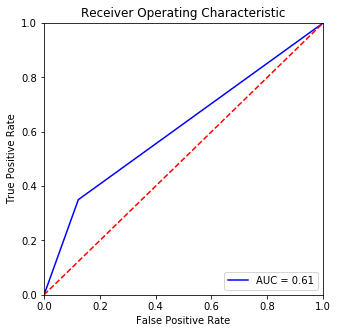

In [110]:
plot_roc(y_test, predictions)

### 3.2 Evaluate a Larger Network
A neural network topology with __more layers__ offers more opportunity for the network to extract key features and __recombine features in useful nonlinear ways__.

We can evaluate whether adding more layers to the network improves the performance easily by making another small tweak to the function used to create our model. Here, we add one new layer (one line) to the network that introduces another hidden layer with 30 neurons after the first hidden layer.

Our network now has the topology:

In [114]:
# larger model
def create_larger():
    # create model
    model = Sequential()
    model.add(Dense(95, input_dim=input_dim, activation='relu'))
    model.add(Dense(45, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [115]:
create_larger().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 95)                9120      
_________________________________________________________________
dense_104 (Dense)            (None, 45)                4320      
_________________________________________________________________
dense_105 (Dense)            (None, 1)                 46        
Total params: 13,486
Trainable params: 13,486
Non-trainable params: 0
_________________________________________________________________


Our network now has the topology:
```
    95 inputs -> [95 -> 45] -> 1 output
```

In [116]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_larger, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X_train_numerical, y_train, cv=kfold)

In [117]:
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 79.43% (5.05%)


We can see that we do not get a lift in the model performance and standard deviation is higher. This may be statistical noise or a sign that further training is needed.

#### Predicting with larger network

In [118]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_larger, epochs=epochs, batch_size=batch_size, verbose=0)))
pipeline = Pipeline(estimators)

# Fit the model
history = pipeline.fit(X_train_numerical, y_train)

# Predict with the model
y_pred = pipeline.predict(X_test_numerical)
predictions = [round(value[0]) for value in y_pred]

In [119]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       220
           1       0.56      0.46      0.51        80

   micro avg       0.76      0.76      0.76       300
   macro avg       0.69      0.67      0.67       300
weighted avg       0.75      0.76      0.75       300



In [120]:
f1_score(y_test, predictions)

0.5068493150684932

Larger Neural Network gives f1-score __0.50__, lower than the smaller network. Thus confirming above result being lower performing than of smaller network.

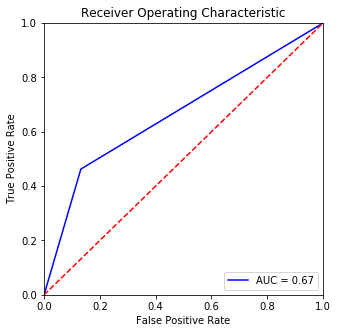

In [121]:
plot_roc(y_test, predictions)

### Comming up next ... Hyperparameter Tuning.
With this approach of manually specifiyng network confguration we won't achieve much in short amount of time. 

To find better performaning network numerous paramters can be modified and network architecture can be changed. In the next notebook we'll find such network with __machine-assisted hyperparameter tuning__.